In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import shutil
import numpy as np

['9_data_1', '9_data_2']

In [1]:
from datasets import wikiset
wikiset.make_embeddings(wikiset.get(),'wiki_segments')
        

f:\progs\python\magister\data\wiki_727K.tar.bz2 found: True
f:\progs\python\magister\data\wiki_test_50.tar.bz2 found: True
Making sentence embeddings...
Loading sentence bert
Embedding sentences:[..........][50/50] => DONE [0h 1min 54s][eta: 0h 0min 0s]   n 0s]     
Making sentence embeddings done in 151.76 s


In [7]:
## load embeddings
import numpy as np
from datasets import EmbeddedDataset
from algorithms import segments
import matplotlib.pyplot as plt
with EmbeddedDataset('choi_segments.npz') as ds:
    print(ds.get_embeddings()[-10:-1])
    seg, emb = ds.get_file('data/961796')
    print(np.min(ds.segment_lengths()))
    print(seg)
    print(segments.tags_to_array(seg))


['3-11/90.ref_emb', '3-11/91.ref_emb', '3-11/92.ref_emb', '3-11/93.ref_emb', '3-11/94.ref_emb', '3-11/95.ref_emb', '3-11/96.ref_emb', '3-11/97.ref_emb', '3-11/98.ref_emb']


KeyError: 'data/961796_seg is not a file in the archive'

[(57, 57), (73, 73), (65, 65), (65, 65), (66, 66), (60, 60), (79, 79), (75, 75), (81, 81), (74, 74)]
[(57, 57), (73, 73), (65, 65), (65, 65), (66, 66), (60, 60), (79, 79), (75, 75), (81, 81), (74, 74)]


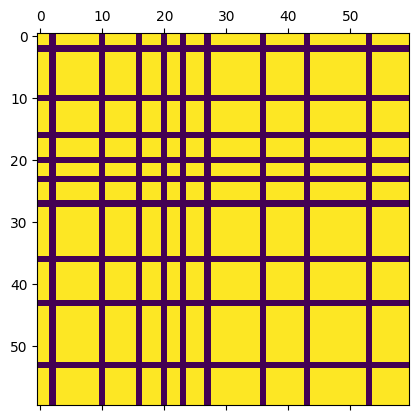

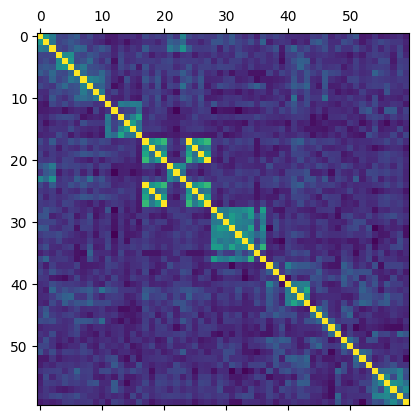

In [8]:
def make_segmat(seg,emb):
    segs = segments.tags_to_array(seg)
    ezemb = np.ones_like(emb[:,0]) * segs
    return np.array([[1-np.clip(i+j,0,1) for j in ezemb] for i in ezemb])

with EmbeddedDataset('choi_segments.npz') as ds:
    Es = ds.get_embeddings()[0:10]
    elist = [np.inner(e,e) for e in ds[Es]]
    ylist = [make_segmat(ds[ds.segmentation(e)],ds[e]) for e in Es]

print([e.shape for e in elist])
print([y.shape for y in ylist])
plt.matshow(ylist[5])
plt.matshow(elist[5])


array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

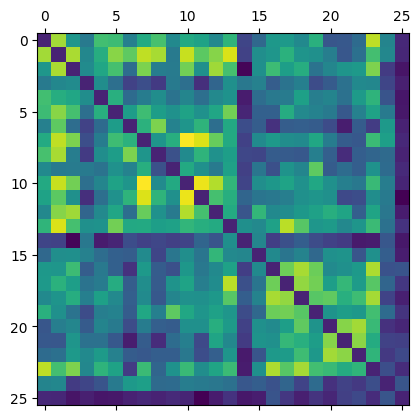

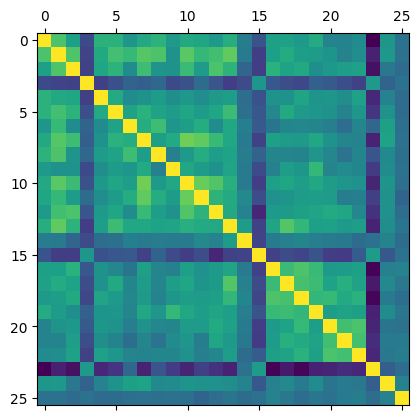

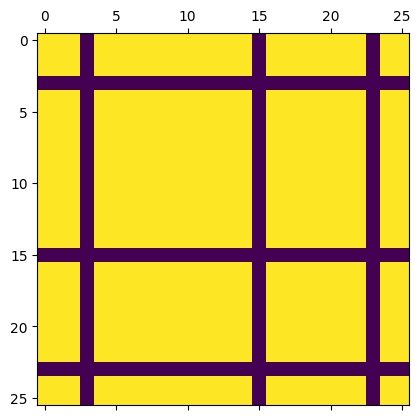

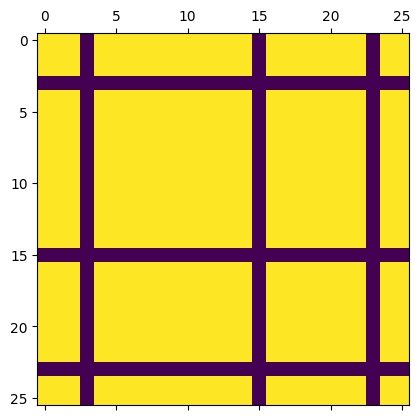

In [40]:
from algorithms import segments
from scipy import signal

mat = np.inner(emb,emb)
segs = segments.tags_to_array(seg)
import matplotlib.pyplot as plt
plt.matshow(mat - np.identity(mat.shape[0]))
eemb = emb * (((segs+1)*-2)+3)[:,np.newaxis]
ezemb = np.ones_like(emb) * segs[:,np.newaxis]
plt.matshow(np.inner(eemb,eemb))
def make_segmat(seg,emb):
    segs = segments.tags_to_array(seg)
    ezemb = np.ones_like(emb[:,0]) * segs
    return np.array([[1-np.clip(i+j,0,1) for j in ezemb] for i in ezemb])

plt.matshow(make_segmat(seg,emb))
plt.matshow(np.mean(mat)*make_segmat(seg,emb))

In [9]:
import tensorflow as tf
autoencoder = tf.keras.models.load_model('models/autoencoder-100e-10k')

In [79]:
import tensorflow as tf
input = tf.keras.layers.Input(shape=(None,None, 1))

# Encoder
ds = tf.keras.layers.BatchNormalization()(input)
x = tf.keras.layers.Conv2D(16, (5, 5), activation='tanh', padding="same")(ds)
x = tf.keras.layers.Conv2D(1, (3, 3), padding="same")(x)
ds = tf.keras.layers.Add()([x,ds])

x = tf.keras.layers.Conv2D(16, (5, 5), activation='tanh', padding="same")(ds)
x = tf.keras.layers.Conv2D(1, (3, 3), padding="same")(x)
ds = tf.keras.layers.Add()([x,ds])

x = tf.keras.layers.Conv2D(16, (5, 5), activation='tanh', padding="same")(ds)
x = tf.keras.layers.Conv2D(1, (3, 3), padding="same")(x)
ds =tf.keras.layers.Add()([x,ds])

x = tf.keras.layers.Conv2D(16, (5, 5), activation='tanh', padding="same")(ds)
x = tf.keras.layers.Conv2D(1, (3, 3), padding="same")(x)
ds = tf.keras.layers.Add()([x,ds])

x = tf.keras.layers.Conv2D(16, (5, 5), activation='tanh', padding="same")(ds)
x = tf.keras.layers.Conv2D(1, (3, 3), padding="same")(x)
ds = tf.keras.layers.Add()([x,ds])

x = tf.keras.layers.Conv2D(16, (5, 5), activation='tanh', padding="same")(ds)
x = tf.keras.layers.Conv2D(1, (3, 3), padding="same")(x)
ds = tf.keras.layers.Add()([x,ds])

x = tf.keras.layers.Conv2D(16, (5, 5), activation='tanh', padding="same")(ds)
x = tf.keras.layers.Conv2D(1, (3, 3), padding="same")(x)
ds = tf.keras.layers.Add()([x,ds])

x = tf.keras.layers.Conv2D(16, (5, 5), activation='tanh', padding="same")(ds)
x = tf.keras.layers.Conv2D(1, (3, 3), padding="same")(x)
ds = tf.keras.layers.Add()([x,ds])

x = tf.keras.layers.Conv2D(16, (5, 5), activation='tanh', padding="same")(ds)
x = tf.keras.layers.Conv2D(1, (3, 3), padding="same")(x)
ds = tf.keras.layers.Add()([x,ds])

x = tf.keras.layers.Conv2D(16, (5, 5), activation='tanh', padding="same")(ds)
x = tf.keras.layers.Conv2D(1, (3, 3), padding="same")(x)
ds = tf.keras.layers.Add()([x,ds])

x = tf.keras.layers.Conv2D(16, (5, 5), activation='tanh', padding="same")(ds)
x = tf.keras.layers.Conv2D(1, (3, 3), padding="same")(x)
ds = tf.keras.layers.Add()([x,ds])

x = tf.keras.layers.Conv2D(16, (5, 5), activation='tanh', padding="same")(ds)
x = tf.keras.layers.Conv2D(1, (3, 3), padding="same")(x)
ds = tf.keras.layers.Add()([x,ds])

x = tf.keras.layers.Conv2D(16, (5, 5), activation='tanh', padding="same")(ds)
x = tf.keras.layers.Conv2D(1, (3, 3), padding="same")(x)
ds = tf.keras.layers.Add()([x,ds])

x = tf.keras.layers.Conv2D(16, (5, 5), activation='tanh', padding="same")(ds)
x = tf.keras.layers.Conv2D(1, (3, 3), padding="same")(x)
ds = tf.keras.layers.Add()([x,ds])

x = tf.keras.layers.Conv2D(16, (5, 5), activation='tanh', padding="same")(ds)
x = tf.keras.layers.Conv2D(1, (3, 3), padding="same")(x)
ds = tf.keras.layers.Add()([x,ds])

x = tf.keras.layers.Conv2D(16, (5, 5), activation='tanh', padding="same")(ds)
x = tf.keras.layers.Conv2D(1, (3, 3), padding="same")(x)
ds = tf.keras.layers.Add()([x,ds])

x = tf.keras.layers.Conv2D(16, (5, 5), activation='tanh', padding="same")(ds)
x = tf.keras.layers.Conv2D(1, (3, 3), padding="same")(x)
ds = tf.keras.layers.Add()([x,ds])

x = tf.keras.layers.Conv2D(16, (5, 5), activation='tanh', padding="same")(ds)
x = tf.keras.layers.Conv2D(1, (3, 3), padding="same")(x)
ds = tf.keras.layers.Add()([x,ds])


autoencoder = tf.keras.Model(input, ds)
mat = np.inner(emb,emb)
autoencoder(np.reshape(mat,(1,*mat.shape,1)))
autoencoder.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 batch_normalization_16 (BatchN  (None, None, None,   4          ['input_20[0][0]']               
 ormalization)                  1)                                                                
                                                                                                  
 conv2d_105 (Conv2D)            (None, None, None,   416         ['batch_normalization_16[0][0]'] 
                                16)                                                        

In [64]:
from math import floor
import tensorflow as tf
class Wiki727Sequence(tf.keras.utils.Sequence):

    def __init__(self, emb_dataset, batch_size):
        self.emb_ds = emb_dataset
        self.emb_ds.open()
        self.batch_size = batch_size
        self.segs_keys = self.emb_ds.get_segments()
        self.embs_keys = self.emb_ds.get_segments()
        self.len = len(self.segs_keys)
        self.emb_ds.close()

    def __len__(self):
        return floor(self.len/self.batch_size)

    def __getitem__(self, idx):
        self.emb_ds.open()
        Es = self.emb_ds.get_embeddings()[idx*self.batch_size : (idx + 1)*self.batch_size]
        
        batch_x = [np.inner(e,e) for e in self.emb_ds[Es]]

        batch_y = tf.ragged.constant([[make_segmat(self.emb_ds[ds.segmentation(e)],self.emb_ds[e]) for e in Es]])
        self.emb_ds.close()
        print(batch_x.shape)

        return batch_x,batch_y

In [80]:
from common import stage
epochs = 100
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

with EmbeddedDataset('wiki_segments.npz') as ds:
    ksegs, kembs = ds.get_segments(), ds.get_embeddings()
    last_loss = 0
    for epoch in range(epochs):
        bar = stage.ProgressBar(f"Epoch [{epoch}/{epochs}] (Loss: {last_loss})",len(ksegs)-10)
        last_loss = 0
        for step in range(len(ksegs)-10):
            bar.update(kembs[step])
            emb, seg = ds[kembs[step]], ds[ksegs[step]]
            X = np.inner(emb,emb)
            X = np.reshape(X,(1,*X.shape,1))
            Y = make_segmat(seg,emb)
            Y = np.reshape(Y,(1,*Y.shape,1))

            with tf.GradientTape() as tape:
                output = autoencoder(X,training= True)
                lossval = loss_fn(Y,output)
            grads = tape.gradient(lossval,autoencoder.trainable_weights)
            optimizer.apply_gradients(zip(grads,autoencoder.trainable_weights))
            last_loss += lossval
        bar.end()


    

Epoch [0/100] (Loss: 0):[..........][40/40] => DONE [0h 0min 26s][eta: 0h 0min 0s]    0min 0s]    
Epoch [1/100] (Loss: 23.579456329345703):[..........][40/40] => DONE [0h 0min 26s][eta: 0h 0min 0s]    0min 0s]    
Epoch [2/100] (Loss: 7.588850021362305):[..........][40/40] => DONE [0h 0min 26s][eta: 0h 0min 0s]    0min 0s]    
Epoch [3/100] (Loss: 7.336544513702393):[..........][40/40] => DONE [0h 0min 28s][eta: 0h 0min 0s]    0min 0s]    
Epoch [4/100] (Loss: 7.1948466300964355):[..........][40/40] => DONE [0h 0min 30s][eta: 0h 0min 0s]    0min 0s]    
Epoch [5/100] (Loss: 7.110968589782715):[..........][40/40] => DONE [0h 0min 26s][eta: 0h 0min 0s]    0min 0s]    
Epoch [6/100] (Loss: 7.0641584396362305):[..........][40/40] => DONE [0h 0min 26s][eta: 0h 0min 0s]    0min 0s]    
Epoch [7/100] (Loss: 7.034617900848389):[..........][40/40] => DONE [0h 0min 25s][eta: 0h 0min 0s]    0min 0s]    
Epoch [8/100] (Loss: 7.008620262145996):[..........][40/40] => DONE [0h 0min 25s][eta: 0h 0mi

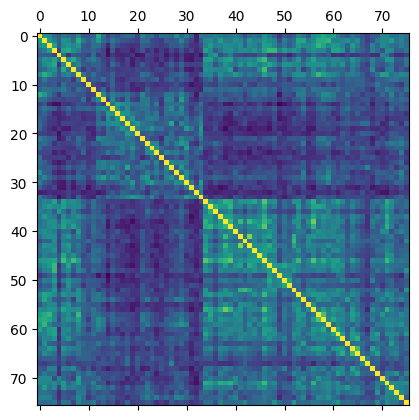

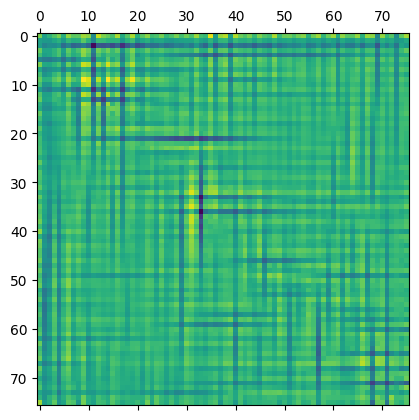

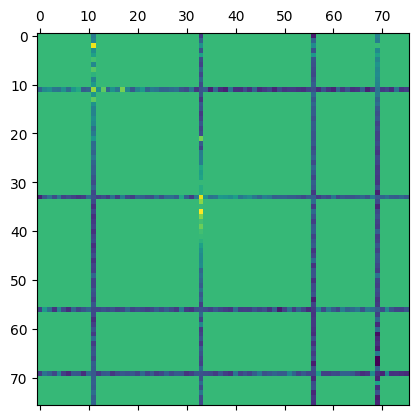

In [10]:
mat = np.inner(emb,emb)
x= np.reshape(mat,(1,*mat.shape,1))
y=autoencoder(x)
plt.matshow(mat)
plt.matshow(np.reshape(y,mat.shape))
plt.matshow(1-(np.reshape(y,mat.shape)*(1-make_segmat(seg,emb))))

In [82]:
autoencoder.save('models/autoencoder-100e-10k')

INFO:tensorflow:Assets written to: models/autoencoder-100e-10k\assets


INFO:tensorflow:Assets written to: models/autoencoder-100e-10k\assets


0.29812944
0.20978339


array([ True,  True, False,  True,  True, False,  True,  True,  True,
        True, False, False])

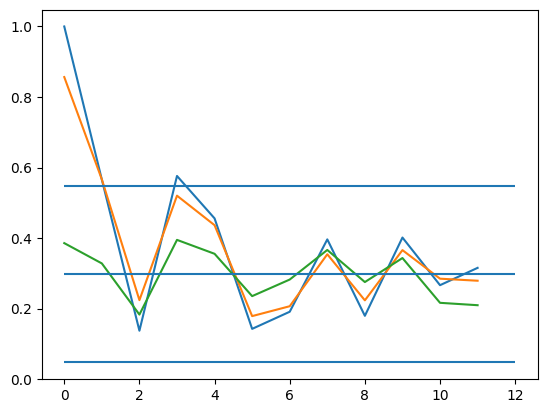

In [48]:

plt.plot(mat[0])
plt.plot(np.convolve(mat[0],[0.1,0.8,0.1],'same'))
print(np.mean(mat))
#plt.plot(mat[145])
print(np.mean(mat[-1]))
plt.plot(np.mean(mat,0))
mean_cross = np.mean(np.mean(mat,0))
std_cross = np.mean(np.std(mat,0))
plt.hlines([mean_cross, mean_cross + std_cross, mean_cross-std_cross],0,len(emb))

tau = np.mean(np.mean(mat,0))-np.std(np.mean(mat,0))/2
np.mean(mat,0) > tau

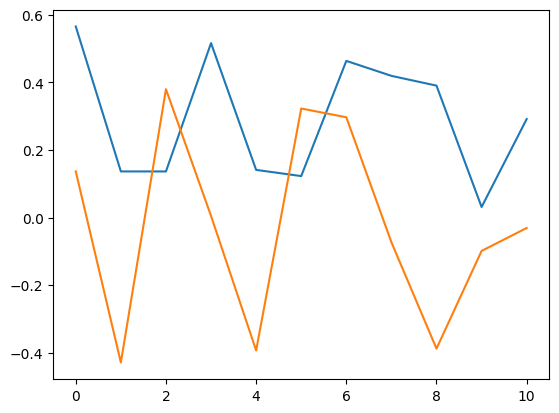

In [7]:
import algorithms
ss = algorithms.sim_score(emb)
plt.plot(ss)
se = np.convolve(ss,[1,0,-1],'same')
plt.plot(se)

[0.5658605, 0.13646336, 0.1363967, 0.51654565, 0.14105415, 0.12268574, 0.46394163, 0.41959375, 0.39063486, 0.031103242, 0.29159153]


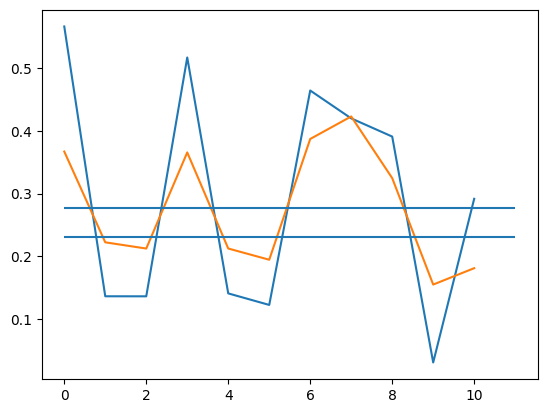

Local minima: [2 5 9]
[0.40473972 0.40480638 0.02465743 0.37384689 0.3922153  0.05095941
 0.07313338 0.08761284 0.39762278]
Embeddings: (12, 512) local_minima: (3,) depth score: (9,) : mean = 0.24551045770446459 : std = 0.16770726609141962 : m-s/2 = 0.16165682465875478
Divisions: (2,)


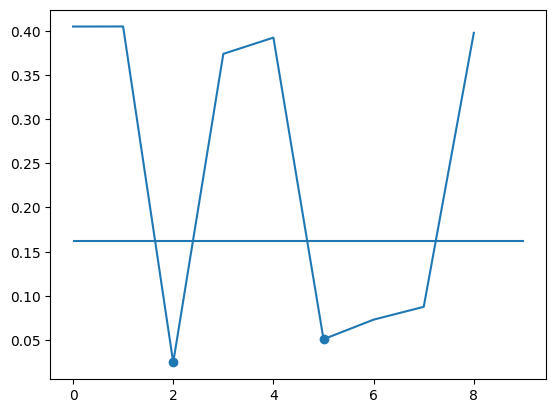

In [8]:
from datasets import choiset, wikiset
from common import files, stage
import numpy as np
import tensorflow_hub as hub
import tensorflow_text
import os, shutil

choiset.make_embeddings(choiset.get(),'choi_segments_cnn', 'cnn')
wikiset.make_embeddings(wikiset.get(),'wiki_segments')
wikiset.make_embeddings(wikiset.get(),'wiki_segments_cnn','cnn')

f:\progs\python\magister\data\Choi-3-11.zip found: True
Making sentence embeddings...
Loading sentence bert...
Loading sentence bert done in 0.00 s
Embedding sentences:[..........][300/300] => DONE [0h 2min 7s][eta: 0h 0min 0s]    0s]      
Making sentence embeddings done in 138.54 s
f:\progs\python\magister\data\wiki_727K.tar.bz2 found: True
f:\progs\python\magister\data\wiki_test_50.tar.bz2 found: True
Making sentence embeddings...
Loading sentence bert...
Loading sentence bert done in 0.00 s
Embedding sentences:[..........][50/50] => DONE [0h 1min 58s][eta: 0h 0min 0s]   n 0s]     
Making sentence embeddings done in 125.73 s
f:\progs\python\magister\data\wiki_727K.tar.bz2 found: True
f:\progs\python\magister\data\wiki_test_50.tar.bz2 found: True
Making sentence embeddings...
Loading sentence bert...
Loading sentence bert done in 0.00 s
Embedding sentences:[..........][50/50] => DONE [0h 0min 15s][eta: 0h 0min 0s]   n 0s]    
Making sentence embeddings done in 16.96 s


Evaluating segmenter...
Evaluating:[..........][300/300] => DONE [0h 0min 3s][eta: 0h 0min 0s]   0min 0s]    
Pmean: 0.19952731577177105 Pstv: 0.08557685377639976
Wmean: 0.22262842501889282 Wstv: 0.09237524553494565
Evaluating segmenter done in 3.19 s
Evaluating segmenter...
Evaluating:[..........][300/300] => DONE [0h 0min 1s][eta: 0h 0min 0s]   0min 0s]    
Pmean: 0.4199001976424485 Pstv: 0.07008623012540491
Wmean: 0.629333138808243 Wstv: 0.08969284198089214
Evaluating segmenter done in 1.77 s
Evaluating segmenter...
Evaluating:[..........][300/300] => DONE [0h 0min 3s][eta: 0h 0min 0s]   0min 0s]    
Pmean: 0.21268829835288316 Pstv: 0.08549047293349202
Wmean: 0.2352502000124763 Wstv: 0.09066497448440004
Evaluating segmenter done in 3.35 s
Evaluating segmenter...
Evaluating:[..........][300/300] => DONE [0h 0min 1s][eta: 0h 0min 0s]   0min 0s]    
Pmean: 0.42052223401596145 Pstv: 0.06339666894339838
Wmean: 0.6358710857163005 Wstv: 0.08185135713854487
Evaluating segmenter done in 1.81

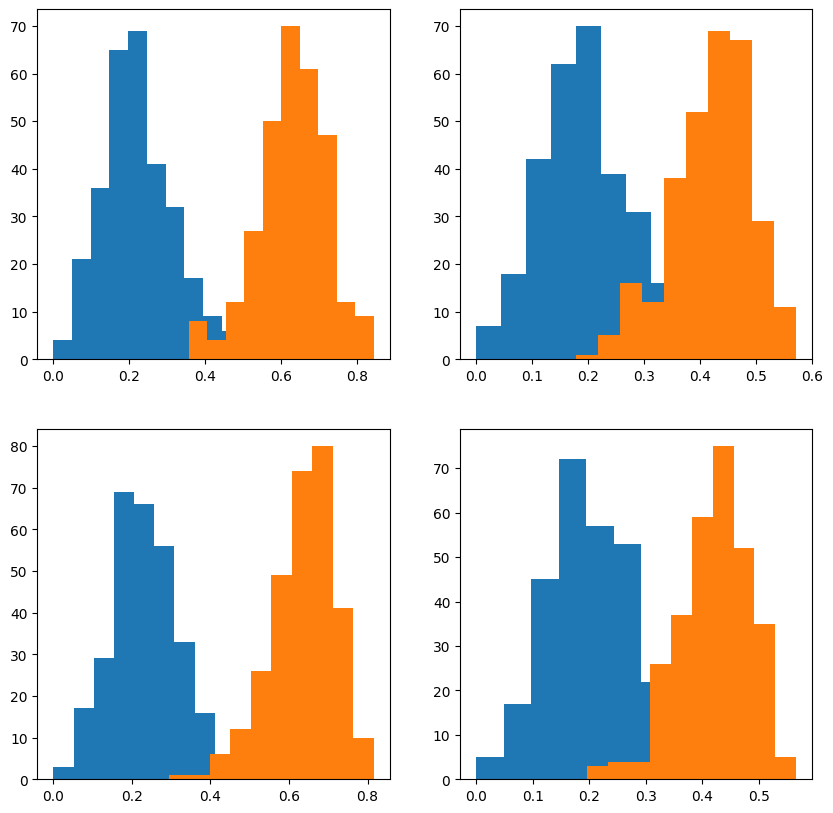

In [9]:
from evaluation import evaluate_segmenter
from algorithms import simple, graphseg
from datasets import EmbeddedDataset
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
gs = graphseg.with_params(0.2,3)
with EmbeddedDataset('choi_segments.npz') as ds:
    p,w = evaluate_segmenter(ds,gs,4)
    plt.subplot(2,2,1)
    plt.hist(w)
    plt.subplot(2,2,2)
    plt.hist(p)
    p,w = evaluate_segmenter(ds,simple.simple_seg,4)
    plt.subplot(2,2,1)
    plt.hist(w)
    plt.subplot(2,2,2)
    plt.hist(p)

with EmbeddedDataset('choi_segments_cnn.npz') as ds:
    p,w = evaluate_segmenter(ds,gs,4)
    plt.subplot(2,2,3)
    plt.hist(w)
    plt.subplot(2,2,4)
    plt.hist(p)
    p,w = evaluate_segmenter(ds,simple.simple_seg,4)
    plt.subplot(2,2,3)
    plt.hist(w)
    plt.subplot(2,2,4)
    plt.hist(p)


Evaluating segmenter...
Evaluating:[..........][50/50] => DONE [0h 0min 6s][eta: 0h 0min 0s]   0min 0s]     
Pmean: 0.5025453437116663 Pstv: 0.20023741255291547
Wmean: 0.5299998704875947 Wstv: 0.19327025670157214
Evaluating segmenter done in 7.90 s
Evaluating segmenter...
Evaluating:[..........][50/50] => DONE [0h 0min 0s][eta: 0h 0min 0s]   0min 0s]    
Pmean: 0.5290992427068079 Pstv: 0.18288776541464485
Wmean: 0.665513544164238 Wstv: 0.1429346933782649
Evaluating segmenter done in 0.29 s
Evaluating segmenter...
Evaluating:[..........][50/50] => DONE [0h 0min 43s][eta: 0h 0min 0s]   0min 0s]     
Pmean: 0.4747127491653964 Pstv: 0.19682736182228278
Wmean: 0.501846961602451 Wstv: 0.1945411376834299
Evaluating segmenter done in 197.99 s
Evaluating segmenter...
 argmin: [3]........  ][41/50] => data/7370490_emb [0h 0min 0s][eta: 0h 0min 0s]   
Evaluating:[..........][50/50] => DONE [0h 0min 0s][eta: 0h 0min 0s]   0min 0s]    
Pmean: 0.5136592774410697 Pstv: 0.1796068634616494
Wmean: 0.658

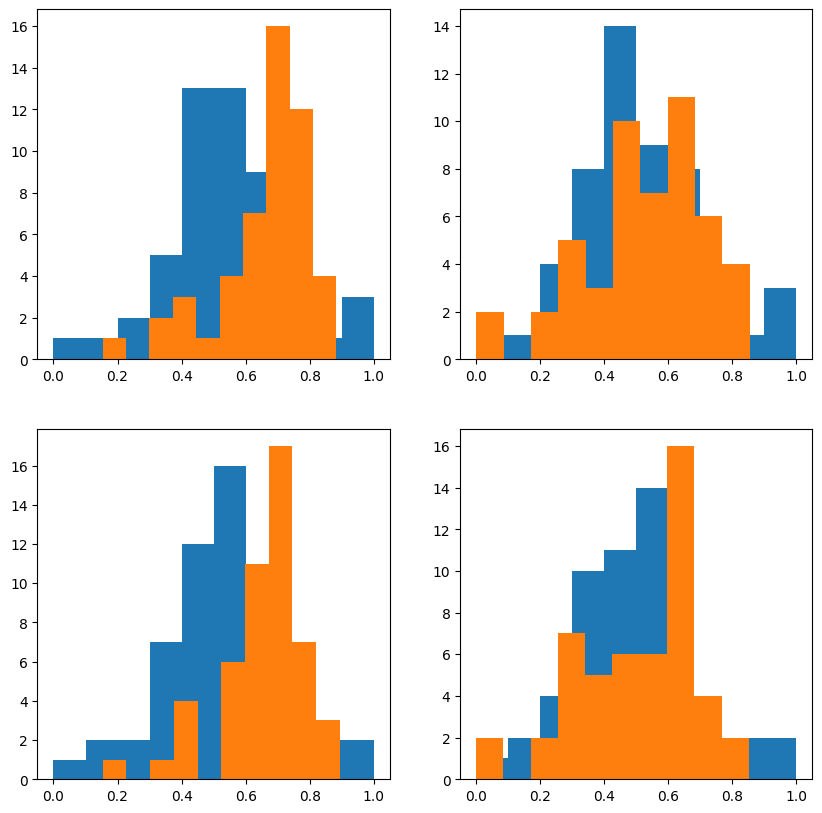

In [12]:
plt.figure(figsize=(10, 10))
gs = graphseg.with_params(0.4,3)
with EmbeddedDataset('wiki_segments.npz') as ds:
    p,w = evaluate_segmenter(ds,gs,4)
    plt.subplot(2,2,1)
    plt.hist(w)
    plt.subplot(2,2,2)
    plt.hist(p)
    p,w = evaluate_segmenter(ds,simple.simple_seg,4)
    plt.subplot(2,2,1)
    plt.hist(w)
    plt.subplot(2,2,2)
    plt.hist(p)

with EmbeddedDataset('wiki_segments_cnn.npz') as ds:
    p,w = evaluate_segmenter(ds,gs,4)
    plt.subplot(2,2,3)
    plt.hist(w)
    plt.subplot(2,2,4)
    plt.hist(p)
    p,w = evaluate_segmenter(ds,simple.simple_seg,4)
    plt.subplot(2,2,3)
    plt.hist(w)
    plt.subplot(2,2,4)
    plt.hist(p)

In [31]:
from nltk.tokenize.texttiling import TextTilingTokenizer
import nltk
from datasets import wikiset
from evaluation import evaluate_document
import algorithms

nltk.download('stopwords')
lines = wikiset.get_unsegmented_lines(wikiset.get(),'data/988580')
text= '\n'.join(lines)
#print(text)
ttt = TextTilingTokenizer(demo_mode=True)
s, ss, d, ttSegmentation = ttt.tokenize(text)
with EmbeddedDataset('wiki_segments.npz') as ds:
   seg, emb = ds.get_file('data/988580')

simpleSegmentation = algorithms.simple_seg(emb)
sgsSegmentation = sbert_graphseg(emb)
print(len(lines))
print(segments.array_to_nltk(np.array(ttSegmentation)))
print(segments.array_to_nltk(segments.tags_to_array(seg)))
print(len(sgsSegmentation))
#evaluate_document(seg,ttSegmentation)



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Radek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


f:\progs\python\magister\data\wiki_727K.tar.bz2 found: True
f:\progs\python\magister\data\wiki_test_50.tar.bz2 found: True
['data/111174', 'data/2640796', 'data/2917712', 'data/10037144', 'data/2952485', 'data/3275069', 'data/6146176', 'data/6544206', 'data/1928841', 'data/12720971', 'data/28187', 'data/7445232', 'data/109461', 'data/7674758', 'data/1198312', 'data/3384438', 'data/2025011', 'data/988580', 'data/149766', 'data/599217', 'data/3881783', 'data/2842974', 'data/31444', 'data/1057453', 'data/1276536', 'data/338825', 'data/9652769', 'data/582816', 'data/961796', 'data/1064845', 'data/380143', 'data/5160544', 'data/7150404', 'data/9387798', 'data/2651177', 'data/7370490', 'data/44426', 'data/6261767', 'data/426889', 'data/6540154', 'data/10648433', 'data/123319', 'data/4074782', 'data/32431', 'data/910628', 'data/8718322', 'data/751683', 'data/2070518', 'data/4823815', 'data/3475652']
149
000001000100010000100010001000010000001000100010000010000000001000000010001000000001000100